# The Fermi-Pasta-Ulam-Tsingou Problem (2D)

In [1]:
"""
================================================================
        The Fermi-Pasta-Ulam-Tsingou (FPUT) Problem (2D)
================================================================
"""

from math import log2
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as PI
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist

#   Improve performance by applying 'jit' decorator
from numba import jit

__version__ = '1.0'


In [2]:
#   CONSTANTS & Parameters
N = int(1e3)                                #   Number of masses

ALPHA = 1.0                                 #   Linear spring constant
BETA = 0.25                                 #   Nonlinear spring constant
# BETA = 0                                    #   No Nonlinear term

t_max = 1e6                                 #   Maximum time
dt = 1e-1                                   #   Time step
num_steps = int(np.ceil(t_max / dt)) + 1    #   Number of time steps
time_points = np.linspace(0, t_max, num_steps)

y0_amp = 1.0        #   Initial displacement amplitude for the first and last points

config_str = f"{int(N)}_{int(ALPHA)}_{int(BETA)}_{int(t_max)}_{int(dt)}"


## 2-Dimensional

First we need to generate evenly spaced out points on a sphere

### Fibonacci Sphere method

In [3]:
@jit
def convert_to_cartesian(spherical_coords):
    phi, theta = spherical_coords.T

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    points = np.vstack((x, y, z)).T             #   Convert 3 arrays into 2D array
                                                #   with 3 columns to each array
    return points


In [4]:
@jit
def generate_fibonacci_sphere_points(n):
    """
    Generates points using Fibonacci Sphere method on a sphere of radius 1
    https://www.designcoding.net/fibonacci-sphere/

    :param  n:      number of points
    
    :return points: 2D numpy array of coordinates [x, y, z] of each points
    """
    i = np.linspace(0.5, n - 0.5, n)            #   Evenly spaced sequence
                                                #   between 0.5 and n - 0.5
    golden_angle = PI * (3 - np.sqrt(5))

    theta = golden_angle * i
    phi = np.arccos(1 - 2 * i / n)

    points = np.vstack((theta, phi)).T          #   Convert 3 arrays into 2D array
                                                #   with 2 columns to each array
    return points

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

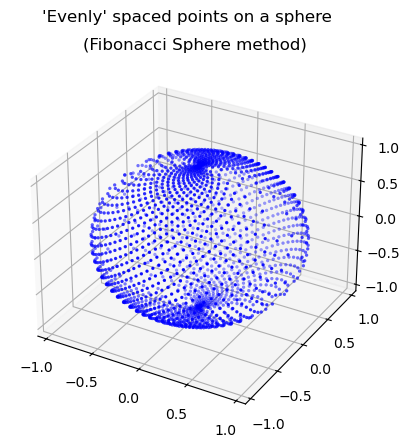

In [30]:
points = convert_to_cartesian(generate_fibonacci_sphere_points(N))

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker = '.', lw = 0.1, color = 'b')

#   Set plot limits and labels
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('(Fibonacci Sphere method)')
fig.suptitle("'Evenly' spaced points on a sphere")
plt.show()


### Electrostatic repulsion method

In [6]:
def initial_positions(n):
    """
    Generates n random points on a sphere of radius 1

    :param  n:      number of points

    :return points: 2D numpy array of coordinates [x, y, z] of each points
    """
    coords = np.random.randn(n, 3)
    norms = np.linalg.norm(coords, axis = 1).reshape(-1, 1)
    
    return coords / norms

def repulsive_forces(points, epsilon):
    """
    Compute forces acting on each point

    :param  points:     2D numpy array of coordinates [x, y, z] of each points
    :param  epsilon:    tolerance for pairwise distance to prevent divide by zero -> NaN

    :return forces:     force vectors acting on each point
    """
    pairwise_distances = cdist(points, points, 'euclidean')
    np.fill_diagonal(pairwise_distances, np.inf)            #   Prevent division by zero
                                                            #   in force calculations
    # Calculate repulsive force magnitude (inverse square law)
    force_magnitudes = 1.0 / (pairwise_distances ** 2 + epsilon ** 2)
    
    # Calculate direction vectors for all pairs
    direction_vectors = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    
    # Normalize direction vectors to unit vectors
    norms = np.linalg.norm(direction_vectors, axis = 2, keepdims = True)
    norms = np.where(norms == 0, np.inf, norms)             #   Avoid division by zero by
                                                            #   replacing 0 with inf
    unit_direction_vectors = direction_vectors / norms
    
    # Calculate forces as vectors
    forces = np.sum(force_magnitudes[:, :, np.newaxis] * unit_direction_vectors, axis = 1)
    
    return forces

def electrostatic_simulate(points, iterations, learning_rate, epsilon, convergence_threshold):
    """
    Simulates time evolution of electrostatic repulsion

    :param  points:                 numpy array of coordinates [x, y, z] of each points
    :param  iterations:             loop count
    :param  learning_rate:          time step
    :param  epsilon:                tolerance for pairwise distance to prevent divide by zero -> NaN
    :param  convergence_threshold:  loop termination condition

    :return points:                 final numpy array of coordinates [x, y, z] of each points
    """
    for i in range(iterations):
        forces = repulsive_forces(points, epsilon)
        delta_points = forces * learning_rate
        points += delta_points
        norms = np.linalg.norm(points, axis = 1).reshape(-1, 1)
        points = points / norms
        
        # Dynamic learning rate adjustment
        if i % 100 == 99:           #   Adjust the learning rate every 100 iterations
            learning_rate *= 0.9    #   Reduce the learning rate to stabilize convergence
        
        # Check for convergence
        max_movement = np.max(np.linalg.norm(delta_points, axis = 1))
        if max_movement < convergence_threshold:
            print(f"Converged after {i + 1} iterations")
            break
    
    return points

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

In [7]:
points = initial_positions(N)


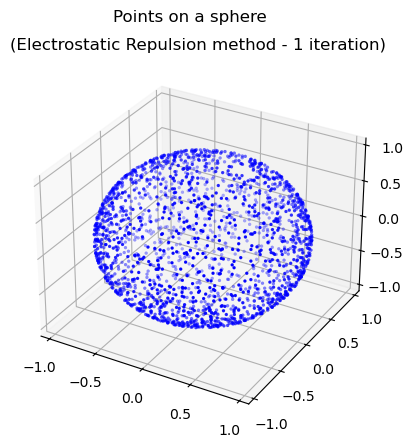

In [29]:
first_points = electrostatic_simulate(points, 1, 1e-4, 1e-32, 1e-7)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(first_points[:, 0], first_points[:, 1], first_points[:, 2], marker = '.', lw = 0.1, color = 'b')

#   Set plot limits and labels
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('(Electrostatic Repulsion method - 1 iteration)')
fig.suptitle('Points on a sphere')
plt.show()


In [9]:
final_points = electrostatic_simulate(points, 1e5, 1e-4, 1e-32, 1e-7)


Converged after 11901 iterations


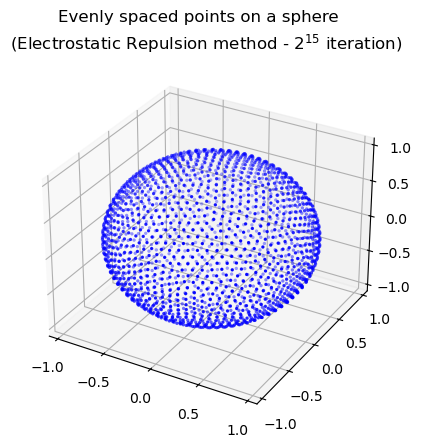

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(final_points[:, 0], final_points[:, 1], final_points[:, 2], marker = '.', lw = 0.1, color = 'b')

#   Set plot limits and labels
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title(r'(Electrostatic Repulsion method - $10^5$ iteration)')
fig.suptitle('Evenly spaced points on a sphere')
plt.show()


In [11]:
np.savetxt(f'./2D_sphere_points.txt', final_points)

### Pairwise distance analysis

In [12]:
def find_closest_neighbors(points, k):
    """
    Finds the k closest neighbors for each point in the dataset

    :param  points:     numpy array of coordinates [x, y, z] of each points
    :param  k:          number of close neighbors to search
    :return indices:    ordered numpy array indices of closest neighbors
    :return distances:  ordered numpy array distances of closest neighbors
    """
    tree = cKDTree(points)          #   Query the k+1 nearest neighbors for each point because
                                    #   the query includes the point itself in the results.
    distances, indices = tree.query(points, k = k + 1)
    
    # Exclude the point itself from its list of closest neighbors
    return indices[:, 1:], distances[:, 1:]

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

In [23]:
n_neighbors = N - 1
neighbors_indices, neighbors_distances = find_closest_neighbors(final_points, n_neighbors)

low_bin = neighbors_distances[neighbors_distances <= 0.1]

mid_bin = neighbors_distances[neighbors_distances >= 0.1]
mid_bin = mid_bin[mid_bin <= 0.125]

high_bin = neighbors_distances[neighbors_distances >= 0.125]
high_bin = high_bin[high_bin <= 0.2]

print(f'Pairwise difference lower than 0.1 units:           {len(low_bin)}')
print(f'Pairwise difference between 0.1 and 0.125 units:    {len(mid_bin)}')
print(f'Pairwise difference between 0.125 and 0.2 units:    {len(high_bin)}')


Pairwise difference lower than 0.1 units:           12038
Pairwise difference between 0.1 and 0.125 units:    438
Pairwise difference between 0.125 and 0.2 units:    24786


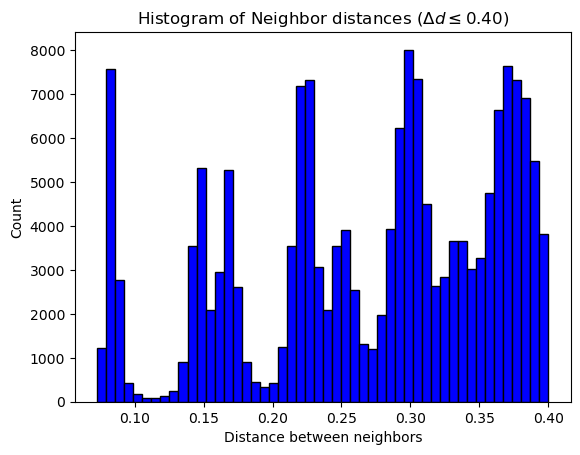

In [20]:
plt.hist(neighbors_distances[neighbors_distances <= 0.40], bins = 50, color = 'b', edgecolor = 'black')
plt.title(r'Histogram of Neighbor distances ($\Delta d\leq 0.40$)')
plt.xlabel('Distance between neighbors')
plt.ylabel('Count')
plt.show()

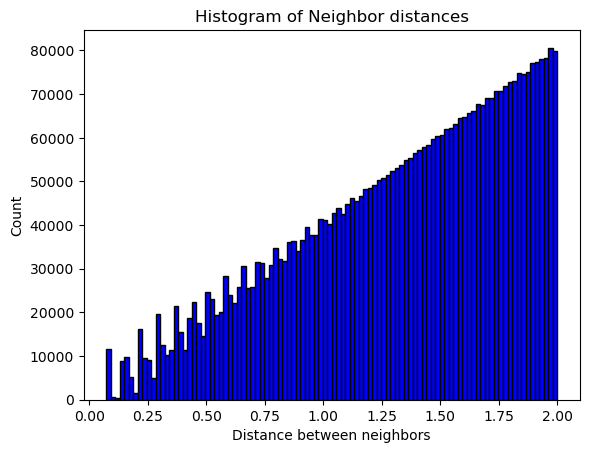

In [15]:
plt.hist(neighbors_distances.flatten(), bins = 100, color = 'b', edgecolor = 'black')
plt.title('Histogram of Neighbor distances')
plt.xlabel('Distance between neighbors')
plt.ylabel('Count')
plt.show()

From this we can see clear clusters of 'concentric' points around an arbitrary point. Thus, we can treat points at the closest cluster <0.225 units away as immediate 'neighboring' points

# <span style="color:red">Run simulations where particles 2+ *particles* away are affected by forces but effects of which are negligible</span>
Plot them against each other